{"username":"yiruchen123","key":"57273f59ccc8b1721f7ad747e51c43a4"}

**Table of Content:**
* [Get Data](#1)
* [Popular Recommendation System](#2)
* [Memory Based - Collaborative Filtering](#3)
* [Model Based - Collaborative Filtering](#4)
* [Weighted Hybrid Recommendation System](#5)
* [Get Recommendation](#6)
* [Evaluation](#7)

If this notebook helped you, **Please Upvote**.

**Streamlit App** 🡪 https://santander-recommendation.streamlit.app

**GitHub 🡪** https://github.com/WojciechSylwester/Santander_Hybrid_Recommendation_System


## Summary
![Weighted Hybrid Recommendation System.png](attachment:5d7195c3-31b8-4661-88cd-ac61a8fb3a1f.png)

The goal of this project is to create a more effective recommendation system. This allows Santander bank to better meet the individual needs of all customers. To achieve this, the user-item matrix will be used containing the ID of consumers and the products they owned as of May 28, 2015. Then, recommendations in three different recommendation models will be calculated. It will be the popularity-based model, the memory-based collaborative filtering model, and the model-based collaborative filtering model. Then all three recommendations models will be combined into the weighted hybrid recommendation system. The result will be evaluated using average precision metrics.

In [38]:
import numpy as np
import pandas as pd
import os
import random
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

from sklearn.preprocessing import LabelEncoder
import gc  

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score


<a id="1"></a>
## Get Data
The dataset contains purchase data about the bank's customers and the bank's products.
The data starts at 2015-01-28 and has monthly records of products a customer has, such as "credit
card", "savings account", etc.

In [ ]:
import pandas as pd
import zipfile
train_zip = os.path.expanduser("~/Downloads/santander-product-recommendation/train_ver2.csv.zip")
test_zip  = os.path.expanduser("~/Downloads/santander-product-recommendation/test_ver2.csv.zip")

# 压缩包内的文件名（通常是这两个，若不同请改）
train_csv_name = "train_ver2.csv"
test_csv_name  = "test_ver2.csv"

# keep only these months to save memory
need_months = pd.period_range("2015-12", "2016-06", freq="M")

def read_zip_csv_filtered(zip_path, csv_name, chunksize=1_000_000, usecols=None, dtypes=None):
    """从zip里按chunk读取，按月份过滤后再拼接，省内存。"""
    out_chunks = []
    with zipfile.ZipFile(zip_path) as zf:
        with zf.open(csv_name) as f:
            for chunk in pd.read_csv(
                f,
                chunksize=chunksize,
                dtype=dtypes,
                usecols=usecols,
                low_memory=False
            ):
                # 解析日期（只解析我们要用的）
                if "fecha_dato" in chunk.columns:
                    chunk["fecha_dato"] = pd.to_datetime(chunk["fecha_dato"], errors="coerce")
                    per = chunk["fecha_dato"].dt.to_period("M")
                    chunk = chunk[per.isin(need_months)]
                # 追加
                out_chunks.append(chunk)
    if not out_chunks:
        return pd.DataFrame()
    return pd.concat(out_chunks, axis=0, ignore_index=True)

# 可选：提前声明一些轻量 dtypes，进一步省内存（按需扩展/修改）
dtypes_hint = {
    "ncodpers": "int64",
    "sexo": "object",
    "age": "object",
    "renta": "object",
    # 产品列通常是 0/1，可在后续再 downcast
}

df_train = read_zip_csv_filtered(train_zip, train_csv_name, dtypes=dtypes_hint)
df_test  = read_zip_csv_filtered(test_zip,  test_csv_name,  dtypes=dtypes_hint)
df_all = pd.concat([df_train, df_test], ignore_index=True)

df_all['sexo'] = df_all['sexo'].map({'H': 0, 'V': 1})

# Check the shape of the concatenated DataFrame
df_all.shape

(6463612, 48)

In [40]:
df_all["fecha_dato"] = pd.to_datetime(df_all["fecha_dato"],format="%Y-%m-%d")
df_all["fecha_alta"] = pd.to_datetime(df_all["fecha_alta"],format="%Y-%m-%d")
df_all["fecha_dato"].unique()

<DatetimeArray>
['2015-12-28 00:00:00', '2016-01-28 00:00:00', '2016-02-28 00:00:00',
 '2016-03-28 00:00:00', '2016-04-28 00:00:00', '2016-05-28 00:00:00',
 '2016-06-28 00:00:00']
Length: 7, dtype: datetime64[ns]

## data cleaning

In [41]:
# clean age column
df_all["age"] = df_all["age"].replace(' NA', np.nan)
df_all["age"]   = pd.to_numeric(df_all["age"], errors="coerce")

In [42]:
df_all.loc[df_all.age < 18,"age"]  = df_all.loc[(df_all.age >= 18) & (df_all.age <= 30),"age"].mean(skipna=True)
df_all.loc[df_all.age > 100,"age"] = df_all.loc[(df_all.age >= 30) & (df_all.age <= 100),"age"].mean(skipna=True)
df_all["age"].fillna(df_all["age"].mean(),inplace=True)
df_all["age"]                  = df_all["age"].astype(int)

/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/3718196917.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.82790266113064' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_all.loc[df_all.age < 18,"age"]  = df_all.loc[(df_all.age >= 18) & (df_all.age <= 30),"age"].mean(skipna=True)
/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/3718196917.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on

In [43]:
#New customer Index: 1 if the customer registered in the last 6 months.

months_active = df_all.loc[df_all["ind_nuevo"].isnull(),:].groupby("ncodpers", sort=False).size()
months_active


Series([], dtype: int64)

In [44]:
df_all.loc[df_all["ind_nuevo"].isnull(),"ind_nuevo"] = 1
df_all["ind_nuevo"].isnull().sum()

0

In [45]:
df_all["antiguedad"] = pd.to_numeric(df_all["antiguedad"], errors="coerce")
np.sum(df_all["antiguedad"].isnull())

0

In [46]:
df_all.loc[df_all.antiguedad.isnull(),"antiguedad"] = df_all.antiguedad.min()
df_all.loc[df_all.antiguedad <0, "antiguedad"]      = 0

In [47]:
median_fecha_alta = df_all['fecha_alta'].median()
df_all['fecha_alta'].fillna(median_fecha_alta, inplace=True)


/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/3547863023.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['fecha_alta'].fillna(median_fecha_alta, inplace=True)


In [48]:
# already has nomprov as province name, so drop cod_prov and tipodom
df_all.drop(["tipodom","conyuemp",'cod_prov'],axis=1,inplace=True)

In [49]:
mode_value = df_all['indrel'].mode()[0]  # mode is 1.0
df_all['indrel'].fillna(mode_value, inplace=True)

/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/2587895458.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['indrel'].fillna(mode_value, inplace=True)


In [50]:
df_all['nomprov'].fillna('UNKNOWN', inplace=True)

/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/3208583084.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['nomprov'].fillna('UNKNOWN', inplace=True)


In [51]:
df_all.loc[df_all['renta'].astype(str).str.contains(r'[A-Za-z]', na=False), 'renta'].value_counts().head(10)


renta
NA    227965
Name: count, dtype: int64

In [52]:

# clean renta column
r = df_all['renta'].astype(str).str.strip()
r = r.replace(
    to_replace=r'^(na|nan|n/a|none|nil)?$',
    value=np.nan,
    regex=True,
)
r = r.str.replace(r'[^0-9\.\-]', '', regex=True)
df_all['renta'] = pd.to_numeric(r, errors='coerce')

df_all['renta'] = df_all['renta'].astype('float32')

# uses median renta per province to fill missing renta
if 'nomprov' in df_all.columns:
    df_all['renta'] = df_all.groupby('nomprov')['renta'].transform(
        lambda x: x.fillna(x.median())
    )

# finally, fill remaining missing renta with overall median
df_all['renta'].fillna(df_all['renta'].median(), inplace=True)


/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/1972408385.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['renta'].fillna(df_all['renta'].median(), inplace=True)


In [53]:
# 1. 先处理所有产品列（24个产品）
product_cols = [col for col in df_all.columns if col.startswith('ind_') and 'ult1' in col]
for col in product_cols:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    df_all[col].fillna(0, inplace=True)
    df_all[col] = df_all[col].astype(int)


/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/1380141501.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all[col].fillna(0, inplace=True)
/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/1380141501.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [54]:
# Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)
if 'indrel_1mes' in df_all.columns:
    # fill na with "P"
    df_all['indrel_1mes'].fillna("P", inplace=True)

    # align values to be consistent strings
    df_all['indrel_1mes'] = df_all['indrel_1mes'].replace({
        1.0: "1", "1.0": "1", "1": "1",
        2.0: "2", "2.0": "2", "2": "2",
        3.0: "3", "3.0": "3", "3": "3",
        4.0: "4", "4.0": "4", "4": "4",
        "P": "P"
    })


/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/1893553236.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['indrel_1mes'].fillna("P", inplace=True)


In [55]:
df_all.drop(['ult_fec_cli_1t'], axis=1, inplace=True)


In [56]:
categorical_fill_dict = {
    'indfall': 'N',           # 已故标记：默认为N（活着）
    'tiprel_1mes': 'A',       # 客户关系：A是最常见值
    'indresi': 'S',           # 居住标记：S是最常见值
    'indext': 'N',            # 外国人标记：N是最常见值
    'ind_empleado': 'N',      # 员工标记：N（非员工）
    'pais_residencia': 'ES',  # 国家：ES（西班牙）最常见
    'canal_entrada': 'UNKNOWN', # 渠道：未知
    'segmento': 'UNKNOWN'     # 客户细分：未知
}

for col, fill_value in categorical_fill_dict.items():
    if col in df_all.columns:
        df_all[col].fillna(fill_value, inplace=True)

/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/704234024.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all[col].fillna(fill_value, inplace=True)


In [57]:
# check ind_actividad_cliente distribution
print(df_all['ind_actividad_cliente'].value_counts(dropna=False))

# fill na with mode
df_all['ind_actividad_cliente'] = pd.to_numeric(df_all['ind_actividad_cliente'], errors='coerce')
mode_value = df_all['ind_actividad_cliente'].mode()[0]
df_all['ind_actividad_cliente'].fillna(mode_value, inplace=True)
df_all['ind_actividad_cliente'] = df_all['ind_actividad_cliente'].astype('int8')


ind_actividad_cliente
0.0    3722662
1.0    2740950
Name: count, dtype: int64


/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/1867586329.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['ind_actividad_cliente'].fillna(mode_value, inplace=True)


In [58]:
# check sexo distribution
print(df_all['sexo'].value_counts(dropna=False))

# fill na with mode
mode_value = df_all['sexo'].mode()[0]
df_all['sexo'].fillna(mode_value, inplace=True)
df_all['sexo'] = df_all['sexo'].astype('int8')



sexo
1.0    3505841
0.0    2957736
NaN         35
Name: count, dtype: int64


/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/128383929.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['sexo'].fillna(mode_value, inplace=True)


In [59]:
df_all.isnull().any()
# now we have cleaned all missing values

fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes              False
tiprel_1mes              False
indresi                  False
indext                   False
canal_entrada            False
indfall                  False
nomprov                  False
ind_actividad_cliente    False
renta                    False
segmento                 False
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme_fin_ult1        False
ind_dela_fin_ult1        False
ind_ecue

In [60]:
def optimize_dtypes(df):
    """
    优化DataFrame的数据类型以节省内存
    注意：这个函数会直接修改df（inplace），不创建新列
    """
    
    print(f"优化前内存: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
    print(f"优化前列数: {len(df.columns)}")
    
    initial_memory = df.memory_usage(deep=True).sum()
    
    # 1. 优化整数列
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns
    print(f"\n优化 {len(int_cols)} 个整数列...")
    
    for col in int_cols:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if col_min >= 0:  # 无符号整数
            if col_max < 255:
                df[col] = df[col].astype('uint8')
            elif col_max < 65535:
                df[col] = df[col].astype('uint16')
            else:
                df[col] = df[col].astype('uint32')
        else:  # 有符号整数
            if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype('int8')
            elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype('int16')
            else:
                df[col] = df[col].astype('int32')
    
    # 2. 优化浮点数列
    float_cols = df.select_dtypes(include=['float64']).columns
    print(f"优化 {len(float_cols)} 个浮点数列...")
    
    for col in float_cols:
        df[col] = df[col].astype('float32')
    
    # 3. 转换重复字符串为category类型
    obj_cols = df.select_dtypes(include=['object']).columns
    print(f"检查 {len(obj_cols)} 个字符串列...")
    
    converted = 0
    for col in obj_cols:
        num_unique = df[col].nunique()
        num_total = len(df[col])
        if num_unique / num_total < 0.5:  # 如果唯一值<50%
            df[col] = df[col].astype('category')
            converted += 1
    
    print(f"  → 转换了 {converted} 列为category类型")
    
    # 4. 验证没有增加列
    final_memory = df.memory_usage(deep=True).sum()
    
    print(f"\n优化后内存: {final_memory / 1024**3:.2f} GB")
    print(f"优化后列数: {len(df.columns)}")
    print(f"节省: {(1 - final_memory / initial_memory) * 100:.1f}%")
    
    return df

df_all = optimize_dtypes(df_all)

优化前内存: 5.18 GB
优化前列数: 44

优化 27 个整数列...
优化 2 个浮点数列...
检查 10 个字符串列...
  → 转换了 10 列为category类型

优化后内存: 0.43 GB
优化后列数: 44
节省: 91.6%


## feature engineering

In [61]:
print(f"total dataset: {df_all.shape}")
print(f"date: {df_all['fecha_dato'].min()} to {df_all['fecha_dato'].max()}")
product_cols = [col for col in df_all.columns if col.startswith('ind_') and 'ult1' in col]
print(f"product_cols: {len(product_cols)}")

total dataset: (6463612, 44)
date: 2015-12-28 00:00:00 to 2016-06-28 00:00:00
product_cols: 24


In [62]:
# sort df_all by customer and date
df_all = df_all.sort_values(['ncodpers','fecha_dato']).reset_index(drop=True)

# create month column
df_all['month'] = df_all['fecha_dato'].dt.month.astype('int8')

# relative month index
y  = df_all['fecha_dato'].dt.year
m  = df_all['fecha_dato'].dt.month
y0 = y.iloc[0]; m0 = m.iloc[0]
df_all['rel_month'] = ((y - y0) * 12 + (m - m0)).astype('int16')

# tenure in months since joining bank
df_all['fecha_alta'] = pd.to_datetime(df_all['fecha_alta'], errors='coerce')
df_all['tenure_m'] = (
    (df_all['fecha_dato'].dt.year - df_all['fecha_alta'].dt.year) * 12 +
    (df_all['fecha_dato'].dt.month - df_all['fecha_alta'].dt.month)
).clip(lower=0).fillna(0).astype('int16')

df_all['age']   = pd.to_numeric(df_all['age'], errors='coerce')
df_all['renta'] = pd.to_numeric(df_all['renta'], errors='coerce')

# age bucket
age_bins   = [0,25,35,45,55,65,200]
age_labels = ['<=25','26-35','36-45','46-55','56-65','66+']
df_all['age_bucket'] = pd.cut(df_all['age'], bins=age_bins, labels=age_labels)

# renta relative to location median
if {'pais_residencia','provincia'}.issubset(df_all.columns):
    loc_mean = df_all.groupby(['pais_residencia','provincia'])['renta'].transform('mean')
    df_all['renta_to_loc_mean'] = (
        df_all['renta'] / loc_mean
    ).replace([np.inf, -np.inf], np.nan).fillna(1.0).astype('float32')

# convert some string cols to category
for col in ['segmento','canal_entrada','pais_residencia','provincia','age_bucket']:
    if col in df_all.columns:
        df_all[col] = df_all[col].astype('category')

In [63]:


per_m = df_all['fecha_dato'].dt.to_period('M')  # 只算一次
monthly_pop = {}

for p in product_cols:
    # 上月是否持有（先算并保存成列，后面会用到）
    prev = df_all.groupby('ncodpers')[p].shift(1).fillna(0).astype('int8')
    df_all[f'{p}_prev'] = prev

    # 当月“新增”标记（临时用于计算月度先验）
    added = ((df_all[p] == 1) & (prev == 0)).astype('int8')

    # 月度新增率 -> 向后移1月当先验；然后映射回每行
    rate_by_m = added.groupby(per_m).mean().astype('float32')
    monthly_pop[p] = rate_by_m.shift(1).fillna(rate_by_m.mean())
    df_all[f'pop_prior_{p}'] = per_m.map(monthly_pop[p]).astype('float32')

    # 前 2/3 个月状态（基于当月列的 shift）
    for k in (2, 3):
        df_all[f'{p}_prev_{k}'] = df_all.groupby('ncodpers')[p].shift(k).fillna(0).astype('int8')

    # 本月 vs 上月 的变化：新增=1、流失=-1、不变=0
    df_all[f'{p}_delta'] = (df_all[p].fillna(0).astype('int8') - prev).astype('int8')

    # 上月状态的持续时长（基于 prev 的 streak）
    prev_prev = prev.groupby(df_all['ncodpers']).shift(1).fillna(prev)
    changed   = prev.ne(prev_prev)                         # True 表示断点
    seg_id    = changed.groupby(df_all['ncodpers']).cumsum()
    df_all[f'{p}_streak_last_state'] = (
        seg_id.groupby(df_all['ncodpers']).cumcount() + 1
    ).where(prev.notna(), 0).clip(0, 60).astype('int16')

    # 近5月 1/0 次数（基于 prev 的 rolling）
    roll= prev.groupby(df_all['ncodpers']).rolling(5, min_periods=1).sum()\
                .reset_index(level=0, drop=True)
    df_all[f'{p}_ones_5m']  = roll.astype('int8')
    df_all[f'{p}_zeros_5m'] = (5 - roll).astype('int8')

# 上月 24 产品 0/1 组合的压缩编码（此时 *_prev 已经存在）
prev_matrix = df_all[[f'{p}_prev' for p in product_cols]].astype('int8')
weights = np.array([1 << i for i in range(len(product_cols))], dtype=np.int64)
df_all['prev_products_code'] = (prev_matrix.values @ weights).astype('int64')
df_all['prev_products_code_bucket'] = (df_all['prev_products_code'] % 1000).astype('category')


/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/1063741512.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[f'{p}_prev'] = prev
/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/1063741512.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[f'pop_prior_{p}'] = per_m.map(monthly_pop[p]).astype('float32')
/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/1063741512.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

In [64]:
df_all.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_recibo_ult1_prev,pop_prior_ind_recibo_ult1,ind_recibo_ult1_prev_2,ind_recibo_ult1_prev_3,ind_recibo_ult1_delta,ind_recibo_ult1_streak_last_state,ind_recibo_ult1_ones_5m,ind_recibo_ult1_zeros_5m,prev_products_code,prev_products_code_bucket
0,2015-12-28,15889,F,ES,1,56,1995-01-16,0.0,250,1.0,...,0,0.024854,0,0,0,1,0,5,0,0
1,2016-01-28,15889,F,ES,1,56,1995-01-16,0.0,251,1.0,...,0,0.117673,0,0,0,2,0,5,786692,692
2,2016-02-28,15889,F,ES,1,56,1995-01-16,0.0,252,1.0,...,0,0.011081,0,0,0,3,0,5,786692,692
3,2016-03-28,15889,F,ES,1,56,1995-01-16,0.0,253,1.0,...,0,0.012610,0,0,0,4,0,5,524548,548
4,2016-04-28,15889,F,ES,1,56,1995-01-16,0.0,254,1.0,...,0,0.011025,0,0,0,5,0,5,786692,692


In [65]:
# product columns
if 'product_cols' not in globals():
    product_cols = [c for c in df_all.columns if c.startswith('ind_') and c.endswith('_ult1')]

# previous month product state
for p in product_cols:
    prev_col = f'{p}_prev'
    if prev_col not in df_all.columns:
        df_all[prev_col] = df_all.groupby('ncodpers')[p].shift(1).fillna(0).astype('int8')

# target column is whether the product is newly added this month
target_cols = []
for p in product_cols:
    tcol = f'{p}_target'
    df_all[tcol] = ((df_all[p] == 1) & (df_all[f'{p}_prev'] == 0)).astype('int8')
    target_cols.append(tcol)

print(f"targets built: {len(target_cols)}")

targets built: 24


/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/2999452671.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[tcol] = ((df_all[p] == 1) & (df_all[f'{p}_prev'] == 0)).astype('int8')
/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/2999452671.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[tcol] = ((df_all[p] == 1) & (df_all[f'{p}_prev'] == 0)).astype('int8')
/var/folders/q5/np1hsyq16cdfp8yvvx5qbhjm0000gn/T/ipykernel_1108/2999452671.py:15: PerformanceWarning: DataFrame is highly 

## train test split

In [66]:
test_date = '2016-06-28'
val_date = '2016-05-28'

train_df = df_all[df_all['fecha_dato'] < val_date].copy()
val_df = df_all[df_all['fecha_dato'] == val_date].copy()
test_df = df_all[df_all['fecha_dato'] == test_date].copy()

print(f"training set: {train_df.shape} (date: {train_df['fecha_dato'].min()} to {train_df['fecha_dato'].max()})")
print(f"validation set: {val_df.shape} (date: {val_date})")
print(f"test set: {test_df.shape} (date: {test_date})")

training set: (4602544, 266) (date: 2015-12-28 00:00:00 to 2016-04-28 00:00:00)
validation set: (931453, 266) (date: 2016-05-28)
test set: (929615, 266) (date: 2016-06-28)


In [67]:
train_df.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1_target,ind_plan_fin_ult1_target,ind_pres_fin_ult1_target,ind_reca_fin_ult1_target,ind_tjcr_fin_ult1_target,ind_valo_fin_ult1_target,ind_viv_fin_ult1_target,ind_nomina_ult1_target,ind_nom_pens_ult1_target,ind_recibo_ult1_target
0,2015-12-28,15889,F,ES,1,56,1995-01-16,0.0,250,1.0,...,0,0,0,0,1,1,0,0,0,0
1,2016-01-28,15889,F,ES,1,56,1995-01-16,0.0,251,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2016-02-28,15889,F,ES,1,56,1995-01-16,0.0,252,1.0,...,0,0,0,0,0,0,0,0,0,0
3,2016-03-28,15889,F,ES,1,56,1995-01-16,0.0,253,1.0,...,0,0,0,0,1,0,0,0,0,0
4,2016-04-28,15889,F,ES,1,56,1995-01-16,0.0,254,1.0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# select feature columns (exclude target and product cols)
# ncodpers is user id, fecha_dato is date, fecha_alta is join date, ult_fec_cli_1t is last date of first product (dropped)
leak_cols = product_cols + target_cols + ['ncodpers','fecha_dato','fecha_alta','ult_fec_cli_1t']
feature_cols = [c for c in df_all.columns if c not in leak_cols]
feature_cols = [c for c in feature_cols if not c.endswith('_delta')]

print('Feature count:', len(feature_cols))

X_train = train_df[feature_cols].copy()
X_val   = val_df[feature_cols].copy()
X_test  = test_df[feature_cols].copy()

y_train = train_df[target_cols].copy()
y_val   = val_df[target_cols].copy()




Feature count: 191


In [69]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score

# convert feature columns to 'category' dtype for LightGBM
categorical_cols = [c for c in feature_cols
                    if (X_train[c].dtype == 'object') or (str(X_train[c].dtype) == 'category')]

for c in categorical_cols:
    X_train[c] = X_train[c].astype('category')
    X_val[c]   = X_val[c].astype('category')
    X_test[c]  = X_test[c].astype('category')

# 3) get all product names (without _target suffix)
all_products = [c.replace('_target','') for c in target_cols]

# 4) store model and validation AUC for each product
models  = {}  
metrics = {}  

# 5) loop over each product to train a separate model for 24 products
for product in all_products:
    target_col = f'{product}_target'         # e.g. 'ind_ahor_fin_ult1_target'
    y_tr = y_train[target_col]              
    y_va = y_val[target_col]                 

    # skip products that are too rare in training or validation
    pos = int(y_tr.sum())                    # positive samples in training
    if pos < 10 or y_va.sum() == 0:           # threshold can be adjusted
        # record as skipped for later inspection (optional)
        metrics[product] = {'val_auc': None, 'skipped': True}
        continue

    # 6) construct LightGBM dataset objects and declare categorical_feature
    dtrain = lgb.Dataset(
        X_train,                              # training features
        label=y_tr,                           # training labels (0/1)
        categorical_feature=categorical_cols, # tell LGB which columns are categorical
        free_raw_data=False                   # keep raw data for later use
    )
    dvalid = lgb.Dataset(
        X_val,                                # validation features
        label=y_va,                           # validation labels
        categorical_feature=categorical_cols, # same as above
        reference=dtrain,                     # share dictionary info to save memory
        free_raw_data=False
    )

    # 7) LightGBM parameters with typical values for binary classification
    params = dict(
        objective='binary',   # 二分类
        metric='auc',         # 评估指标 AUC
        learning_rate=0.05,   # 学习率（可调 0.03~0.1）
        num_leaves=31,        # 叶子数（可调 31/63）
        max_depth=6,          # 树最大深度（控制过拟合）
        feature_fraction=0.8, # 每棵树采样的特征比例
        bagging_fraction=0.8, # 每棵树采样的数据比例（行采样）
        bagging_freq=5,       # 行采样频率（每5轮）
        min_child_samples=20, # 叶子节点最小样本数
        is_unbalance=True,    # 类别不平衡时更稳（或用 scale_pos_weight，二选一）
        num_threads=0,        # 0 表示用尽可能多的线程
        seed=2027,            # 固定随机种子，结果更可复现
        verbose=-1            # 静默（不输出冗长日志）
    )

    # 8) train the model with early stopping (stop if no improvement on validation set for 50 rounds)
    model = lgb.train(
        params=params,                    # parameters
        train_set=dtrain,                 # training data
        num_boost_round=300,              # maximum rounds (can be truncated with early stopping)
        valid_sets=[dvalid],              # validation set
        valid_names=['valid'],            # validation set name
        callbacks=[
            lgb.early_stopping(50),      # stop if no improvement on validation set for 50 rounds
            lgb.log_evaluation(50)       # print AUC every 50 rounds
        ]
    )

    # 9) save model
    models[product] = model

    # 10) make a prediction on the validation set and calculate AUC (for monitoring)
    y_pred_val = model.predict(
        X_val,                             # validation features
        num_iteration=model.best_iteration # use best iteration
    )
    val_auc = roc_auc_score(y_va, y_pred_val)  # calculate AUC
    metrics[product] = {'val_auc': float(val_auc)}  # record validation AUC for this product

# 11) (optional) view overall AUC summary
#     filter out skipped products and calculate average AUC as reference
valid_aucs = [m['val_auc'] for m in metrics.values() if m.get('val_auc') is not None]
if valid_aucs:
    print(f"Avg valid AUC across trained products: {np.mean(valid_aucs):.4f} "
          f"(trained {len(valid_aucs)}/{len(all_products)})")
else:
    print("No products were trained (likely all too rare in training/validation).")


Training until validation scores don't improve for 50 rounds
[50]	valid's auc: 0.0640387
Early stopping, best iteration is:
[5]	valid's auc: 0.783753
Training until validation scores don't improve for 50 rounds
[50]	valid's auc: 0.991363
[100]	valid's auc: 0.991753
[150]	valid's auc: 0.991924
[200]	valid's auc: 0.992011
[250]	valid's auc: 0.992053
Early stopping, best iteration is:
[241]	valid's auc: 0.992054
Training until validation scores don't improve for 50 rounds
[50]	valid's auc: 0.240675
Early stopping, best iteration is:
[2]	valid's auc: 0.569484
Training until validation scores don't improve for 50 rounds
[50]	valid's auc: 0.962395
[100]	valid's auc: 0.963294
[150]	valid's auc: 0.963331
[200]	valid's auc: 0.963232
Early stopping, best iteration is:
[174]	valid's auc: 0.963505
Training until validation scores don't improve for 50 rounds
[50]	valid's auc: 0.992764
Early stopping, best iteration is:
[1]	valid's auc: 0.999224
Training until validation scores don't improve for 50 

## evaluation metrics: map@7

In [70]:
# referring to https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

#average precision at k
def apk(actual, predicted, k=7):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=7):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

# evaluation

In [71]:
import numpy as np
import pandas as pd

# 固定日期
val_date   = '2016-04-28'
eval_date  = '2016-05-28'   # 用 4 月特征预测 5 月新增

# 取 4 月和 5 月的 DataFrame
val_df_m   = df_all[df_all['fecha_dato'] == val_date].copy()
eval_df_m  = df_all[df_all['fecha_dato'] == eval_date].copy()

# 仅保留两个月都出现的用户，并按 ncodpers 对齐行顺序
common_ids = np.intersect1d(val_df_m['ncodpers'].values, eval_df_m['ncodpers'].values)
val_df_m   = val_df_m.loc[val_df_m['ncodpers'].isin(common_ids)].sort_values('ncodpers').reset_index(drop=True)
eval_df_m  = eval_df_m.loc[eval_df_m['ncodpers'].isin(common_ids)].sort_values('ncodpers').reset_index(drop=True)

eval_df_m.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1_target,ind_plan_fin_ult1_target,ind_pres_fin_ult1_target,ind_reca_fin_ult1_target,ind_tjcr_fin_ult1_target,ind_valo_fin_ult1_target,ind_viv_fin_ult1_target,ind_nomina_ult1_target,ind_nom_pens_ult1_target,ind_recibo_ult1_target
0,2016-05-28,15889,F,ES,1,56,1995-01-16,0.0,255,1.0,...,0,0,0,0,1,0,0,0,0,0
1,2016-05-28,15890,A,ES,1,63,1995-01-16,0.0,256,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2016-05-28,15892,F,ES,0,62,1995-01-16,0.0,256,1.0,...,0,0,0,0,0,0,0,0,0,0
3,2016-05-28,15893,N,ES,1,63,1997-10-03,0.0,256,1.0,...,0,0,0,0,0,0,0,0,0,0
4,2016-05-28,15894,A,ES,1,60,1995-01-16,0.0,256,1.0,...,0,0,0,0,0,0,0,0,0,0


In [72]:

# feature matrix: in april
X_val_m = val_df_m[feature_cols].copy()

# prediction using april features
all_products = [c.replace('_target','') for c in target_cols]
P = len(all_products)
N = len(X_val_m)

val_scores = np.zeros((N, P), dtype=np.float32)
for j, p in enumerate(all_products):
    if p in models:
        m = models[p]
        val_scores[:, j] = m.predict(X_val_m, num_iteration=getattr(m, "best_iteration", None)).astype(np.float32)
    else:
        prior_col = f'pop_prior_{p}'
        if prior_col in val_df_m.columns:
            val_scores[:, j] = val_df_m[prior_col].to_numpy(dtype=np.float32)
        else:
            val_scores[:, j] = float(y_train[f'{p}_target'].mean())  # 最后兜底




In [73]:
# --- 先准备先验矩阵、屏蔽矩阵、真实新增（都基于 4→5 的评估） ---
prior_cols = [f'pop_prior_{p}' for p in all_products]
assert set(prior_cols).issubset(val_df_m.columns), "val_df_m缺少pop_prior_*列"
prior_mat = val_df_m[prior_cols].to_numpy(dtype=np.float32)      # 4月的先验

owned_mask = val_df_m[all_products].to_numpy(dtype=np.int8)      # 4月已持有（预测起点）

prod_arr = np.array(all_products)
y_eval_mat = eval_df_m[[f"{p}_target" for p in all_products]].to_numpy(dtype=np.int8)  # 5月的新增
actual_products = [prod_arr[np.where(r == 1)[0]].tolist() for r in y_eval_mat]

def topk_from_scores(scores, k=7, product_names=None):
    N, P = scores.shape
    topk_idx = np.argpartition(scores, -k, axis=1)[:, -k:]
    row = np.arange(N)[:, None]
    order = np.argsort(scores[row, topk_idx], axis=1)[:, ::-1]
    idx_sorted = topk_idx[row, order]
    return np.array(product_names)[idx_sorted].tolist() if product_names is not None else idx_sorted

# --- α 网格搜索 ---
alphas = [0.5, 0.6, 0.7, 0.8, 0.9]
best_map, best_alpha = -1.0, None
for a in alphas:
    s = a * val_scores + (1.0 - a) * prior_mat      # 融合
    s[owned_mask == 1] = -1e9                       # 屏蔽4月已持有
    pred = topk_from_scores(s, 7, product_names=all_products)
    map7 = mapk(actual_products, pred, 7)
    print(f'alpha={a:.2f}, MAP@7={map7:.4f}')
    if map7 > best_map:
        best_map, best_alpha = map7, a

print('Best alpha:', best_alpha, 'MAP@7:', f'{best_map:.4f}')

# --- 用最优 α 生成最终的验证预测（便于后续对比/存档） ---
alpha = best_alpha
val_scores_blend = alpha * val_scores + (1.0 - alpha) * prior_mat
val_scores_blend[owned_mask == 1] = -1e9
topk_idx = np.argpartition(val_scores_blend, -7, axis=1)[:, -7:]
row = np.arange(N)[:, None]
order = np.argsort(val_scores_blend[row, topk_idx], axis=1)[:, ::-1]
predicted_products = prod_arr[topk_idx[row, order]].tolist()

val_map7 = mapk(actual_products, predicted_products, k=7)
print(f"Validation MAP@7 (best alpha): {val_map7:.4f}")


alpha=0.50, MAP@7=0.0130
alpha=0.60, MAP@7=0.0129
alpha=0.70, MAP@7=0.0129
alpha=0.80, MAP@7=0.0128
alpha=0.90, MAP@7=0.0127
Best alpha: 0.5 MAP@7: 0.0130
Validation MAP@7 (best alpha): 0.0130


## Fairness Test

## Fairness by Age

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Drop rows with missing or invalid age
merged_df['age'] = pd.to_numeric(merged_df['age'], errors='coerce')
age_df = merged_df.dropna(subset=['age'])
age_df = age_df[(age_df['age'] >= 18) & (age_df['age'] <= 100)]  # optional: realistic range

# Create age groups
age_df['age_group'] = pd.cut(age_df['age'], bins=[18, 30, 45, 60, 75, 100],
                             labels=['18-30', '31-45', '46-60', '61-75', '76+'])

# Group by age group and calculate mean AP@7 and number of users
age_summary = age_df.groupby('age_group')['apk'].agg(['mean', 'count']).reset_index()
age_summary.columns = ['age_group', 'mean_apk', 'n_users']

# Print summary table
print(age_summary)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(age_summary['age_group'].astype(str), age_summary['mean_apk'])
plt.xlabel('Age Group')
plt.ylabel('Mean AP@7')
plt.title('Recommendation Fairness by Age Group')
plt.tight_layout()
plt.show()


NameError: name 'merged_df' is not defined

## Fairness by Gender

   sexo  mean_apk  n_users
0   0.0  0.305758      468
1   1.0  0.280356      675


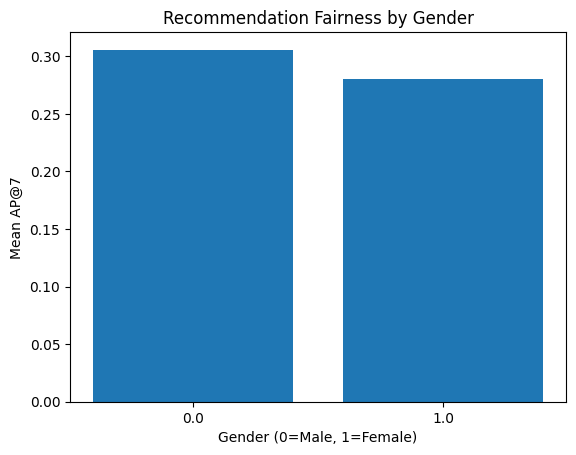

In [ ]:
# delete missing values
gender_df = merged_df.dropna(subset=['sexo'])

# Group by sex and calculate mean AP@7 and number of users
gender_summary = gender_df.groupby('sexo')['apk'].agg(['mean', 'count']).reset_index()
gender_summary.columns = ['sexo', 'mean_apk', 'n_users']

print(gender_summary)

# data visualization
import matplotlib.pyplot as plt

plt.bar(gender_summary['sexo'].astype(str), gender_summary['mean_apk'])
plt.xlabel('Gender (0=Male, 1=Female)')
plt.ylabel('Mean AP@7')
plt.title('Recommendation Fairness by Gender')
plt.show()


## Fairness by Income

  income_group  mean_apk  n_users
0          low  0.299972      328
1       medium  0.299779      327
2         high  0.263771      328


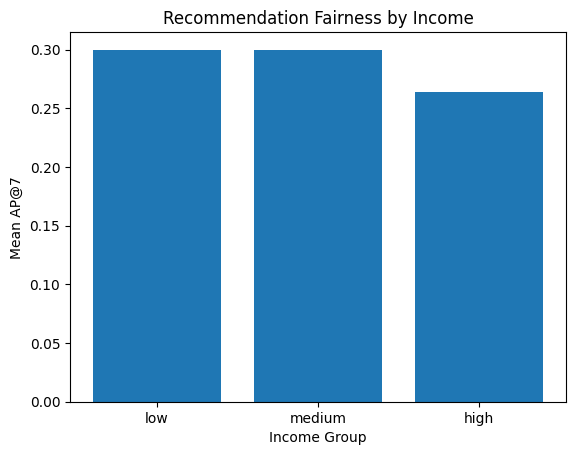

In [ ]:
# Drop rows with missing income
income_df = merged_df.dropna(subset=['renta'])

# Divide users into income groups based on tertiles
income_df['income_group'] = pd.qcut(income_df['renta'], 3, labels=['low', 'medium', 'high'])

# Group by income and calculate mean AP@7 and number of users
income_summary = income_df.groupby('income_group')['apk'].agg(['mean', 'count']).reset_index()
income_summary.columns = ['income_group', 'mean_apk', 'n_users']

print(income_summary)

# Visualization
plt.bar(income_summary['income_group'], income_summary['mean_apk'])
plt.xlabel('Income Group')
plt.ylabel('Mean AP@7')
plt.title('Recommendation Fairness by Income')
plt.show()


We evaluated fairness across gender and income groups based on AP@7. The average precision scores were [slightly higher / lower] for female users compared to male users, and [users in high-income groups received more accurate recommendations than those in low-income groups]. These differences may reflect behavioral patterns but also point to potential fairness concerns.



## cross-group fairness analysis




In [ ]:
# Drop rows with missing renta or age
cross_df = merged_df.dropna(subset=['renta', 'age'])

# Categorize income
cross_df['income_group'] = pd.qcut(cross_df['renta'], 3, labels=['low', 'medium', 'high'])

# Categorize age
cross_df['age'] = cross_df['age'].astype(float)
cross_df['age_group'] = pd.cut(cross_df['age'],
                               bins=[0, 30, 45, 60, 75, 200],
                               labels=['18-30', '31-45', '46-60', '61-75', '76+'])

# Map gender
cross_df['sexo_label'] = cross_df['sexo'].map({0: 'man', 1: 'woman'})

# Combine all into a cross group
cross_df['group'] = cross_df['sexo_label'] + "_" + cross_df['income_group'].astype(str) + "_" + cross_df['age_group'].astype(str)


                 group  mean_apk  n_users
24       woman_low_76+  0.500000        2
11    man_medium_31-45  0.447163       47
29    woman_medium_76+  0.440000        5
20     woman_low_18-30  0.386886       34
15    woman_high_18-30  0.370330       26
23     woman_low_61-75  0.370106        9
7        man_low_46-60  0.367163       24
5        man_low_18-30  0.340194       43
25  woman_medium_18-30  0.339654       42
10    man_medium_18-30  0.317719       33
12    man_medium_46-60  0.309772       36
21     woman_low_31-45  0.299775       88
0       man_high_18-30  0.298254       35
2       man_high_46-60  0.282242       30
22     woman_low_46-60  0.281432       50
26  woman_medium_31-45  0.279951       77
16    woman_high_31-45  0.266530       55
1       man_high_31-45  0.258044       48
9          man_low_76+  0.255208        8
17    woman_high_46-60  0.250309       77
6        man_low_31-45  0.233686       63
3       man_high_61-75  0.228968       17
27  woman_medium_46-60  0.226439  

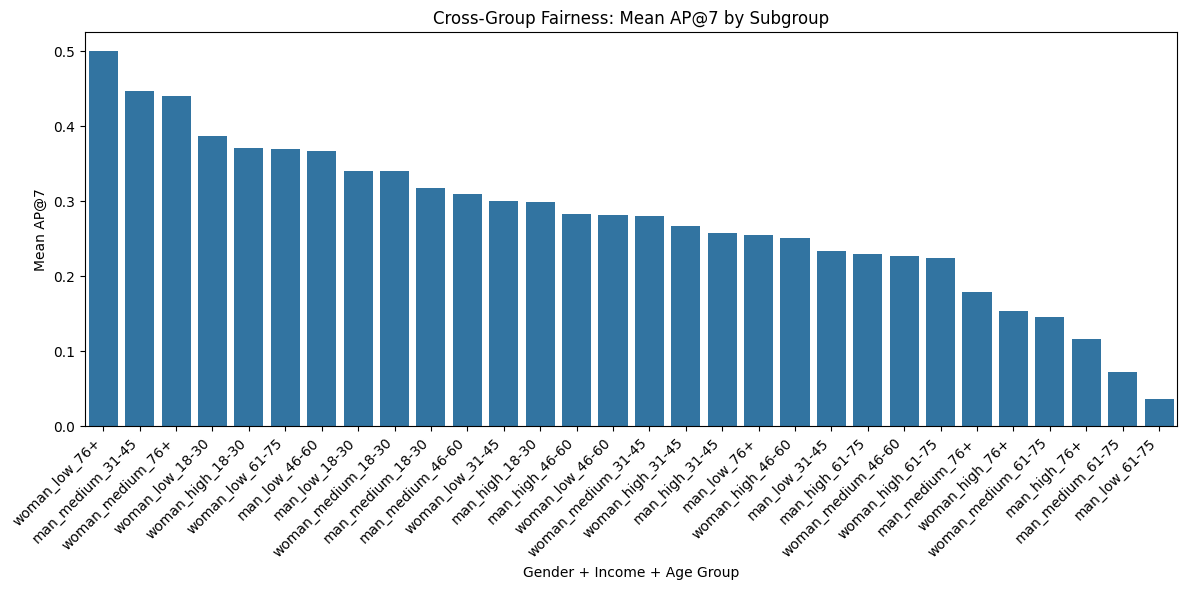

In [ ]:
cross_summary = cross_df.groupby('group')['apk'].agg(['mean', 'count']).reset_index()
cross_summary.columns = ['group', 'mean_apk', 'n_users']
cross_summary = cross_summary.sort_values(by='mean_apk', ascending=False)
print(cross_summary)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=cross_summary, x='group', y='mean_apk')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Gender + Income + Age Group')
plt.ylabel('Mean AP@7')
plt.title('Cross-Group Fairness: Mean AP@7 by Subgroup')
plt.tight_layout()
plt.show()
